<a href="https://colab.research.google.com/github/CACMO/demo/blob/main/quickstart.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

class EquipmentHealthForecasting:
    def __init__(self, n_neighbors=20, contamination=0.1):
        """
        Initialize the Equipment Health Forecasting using LOF algorithm
        
        Parameters:
        -----------
        n_neighbors : int, default=20
            Number of neighbors to consider for LOF calculation
        contamination : float, default=0.1
            Expected proportion of outliers in the dataset
        """
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True  # Set to True for predicting on new data
        )
        self.scaler = StandardScaler()
        self.golden_data = None
        self.feature_importance = None
        
    def train_with_golden_data(self, golden_data):
        """
        Train the model with Golden Data to form Golden Clusters
        
        Parameters:
        -----------
        golden_data : pandas DataFrame
            The "Golden Data" representing normal operating conditions
        """
        # Store original golden data
        self.golden_data = golden_data.copy()
        
        # Preprocess the data
        X = self.scaler.fit_transform(golden_data)
        
        # Fit the LOF model
        self.lof.fit(X)
        
        # Calculate feature importance based on PCA
        pca = PCA(n_components=min(5, golden_data.shape[1]))
        pca.fit(X)
        
        # Store feature importance for later use
        self.feature_importance = pd.DataFrame(
            np.abs(pca.components_),
            columns=golden_data.columns
        )
        
        print(f"Model trained with {golden_data.shape[0]} golden data points")
        return self
    
    def evaluate_health(self, production_data):
        """
        Evaluate equipment health by comparing production data against golden clusters
        
        Parameters:
        -----------
        production_data : pandas DataFrame
            New production data to evaluate
            
        Returns:
        --------
        health_metrics : pandas DataFrame
            DataFrame with health metrics including LOF scores
        """
        if self.golden_data is None:
            raise ValueError("Model not trained. Call train_with_golden_data first.")
            
        # Ensure production data has the same columns as golden data
        if not all(col in production_data.columns for col in self.golden_data.columns):
            raise ValueError("Production data columns don't match golden data columns")
        
        # Extract relevant columns and scale
        X = production_data[self.golden_data.columns]
        X_scaled = self.scaler.transform(X)
        
        # Calculate LOF scores for each data point (-1 * because sklearn returns negative values)
        lof_scores = -1 * self.lof.decision_function(X_scaled)
        
        # Calculate anomaly flag (1 for anomaly, 0 for normal)
        # Note: predict_proba is not available for LOF, so we use a threshold
        anomaly_flag = (lof_scores > 1).astype(int)
        
        # Create health metrics dataframe
        health_metrics = pd.DataFrame({
            'timestamp': production_data.index if isinstance(production_data.index, pd.DatetimeIndex) else None,
            'lof_score': lof_scores,
            'is_anomaly': anomaly_flag
        })
        
        # For anomalies, determine which features contributed most
        if anomaly_flag.sum() > 0:
            anomaly_indices = health_metrics[health_metrics['is_anomaly'] == 1].index
            health_metrics['contributing_features'] = None
            
            for idx in anomaly_indices:
                # Get the data point
                data_point = X_scaled[idx]
                
                # Compare with golden data mean
                golden_mean = np.mean(self.scaler.transform(self.golden_data), axis=0)
                deviation = np.abs(data_point - golden_mean)
                
                # Weight deviation by feature importance
                weighted_deviation = deviation * np.mean(self.feature_importance.values, axis=0)
                
                # Get top 3 contributing features
                top_features_idx = np.argsort(weighted_deviation)[-3:]
                top_features = [self.golden_data.columns[i] for i in top_features_idx]
                
                health_metrics.at[idx, 'contributing_features'] = ', '.join(top_features)
        
        return health_metrics
    
    def visualize_results(self, production_data, health_metrics):
        """
        Visualize the results of equipment health evaluation
        
        Parameters:
        -----------
        production_data : pandas DataFrame
            Production data that was evaluated
        health_metrics : pandas DataFrame
            Health metrics returned by evaluate_health
        """
        if 'timestamp' in health_metrics.columns and health_metrics['timestamp'] is not None:
            # Time series plot of LOF scores
            plt.figure(figsize=(12, 6))
            plt.plot(health_metrics['timestamp'], health_metrics['lof_score'], 'b-', label='LOF Score')
            
            # Highlight anomalies
            anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
            plt.scatter(anomalies['timestamp'], anomalies['lof_score'],
                        color='red', label='Anomalies', s=50)
            
            # Add a threshold line
            plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Threshold')
            
            plt.title('Equipment Health Monitoring: LOF Scores Over Time')
            plt.xlabel('Time')
            plt.ylabel('LOF Score')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # PCA visualization of golden data vs production data
        X_golden = self.scaler.transform(self.golden_data)
        X_prod = self.scaler.transform(production_data[self.golden_data.columns])
        
        # Apply PCA
        pca = PCA(n_components=2)
        X_golden_pca = pca.fit_transform(X_golden)
        X_prod_pca = pca.transform(X_prod)
        
        plt.figure(figsize=(10, 8))
        
        # Plot golden data points
        plt.scatter(X_golden_pca[:, 0], X_golden_pca[:, 1],
                   c='gold', label='Golden Data', alpha=0.5, edgecolors='k')
        
        # Plot normal production data
        normal_idx = health_metrics[health_metrics['is_anomaly'] == 0].index
        plt.scatter(X_prod_pca[normal_idx, 0], X_prod_pca[normal_idx, 1],
                   c='green', label='Normal Production', alpha=0.7)
        
        # Plot anomalies
        anomaly_idx = health_metrics[health_metrics['is_anomaly'] == 1].index
        plt.scatter(X_prod_pca[anomaly_idx, 0], X_prod_pca[anomaly_idx, 1],
                   c='red', label='Anomalies', alpha=0.7, marker='X', s=100)
        
        plt.title('Equipment Data: Golden Clusters vs. Production Data (PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Feature importance visualization
        if len(anomaly_idx) > 0:
            plt.figure(figsize=(12, 8))
            feature_importance = self.feature_importance.mean().sort_values(ascending=False)
            sns.barplot(x=feature_importance.values, y=feature_importance.index)
            plt.title('Feature Importance in Anomaly Detection')
            plt.xlabel('Importance Score')
            plt.ylabel('Features (KeyNumbers)')
            plt.tight_layout()
            plt.show()
        
        return

# Example usage
if __name__ == "__main__":
    # Simulate golden data (normal operating conditions)
    np.random.seed(42)
    n_samples = 1000
    n_features = 8
    
    # Create feature names (KeyNumbers)
    feature_names = [f'KeyNumber_{i+1}' for i in range(n_features)]
    
    # Generate golden data with correlations
    mean = np.zeros(n_features)
    cov = np.eye(n_features)
    # Add some correlations
    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                cov[i, j] = 0.3 if (i+j) % 2 == 0 else 0.1
                
    golden_data = np.random.multivariate_normal(mean, cov, n_samples)
    golden_df = pd.DataFrame(golden_data, columns=feature_names)
    
    # Create timestamp index
    date_rng = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')
    golden_df.index = date_rng
    
    # Simulate production data (includes some anomalies)
    n_prod_samples = 200
    date_rng_prod = pd.date_range(start='2024-03-01', periods=n_prod_samples, freq='H')
    
    # Normal production data
    prod_data = np.random.multivariate_normal(mean, cov, n_prod_samples)
    
    # Introduce some anomalies
    anomaly_indices = [20, 50, 51, 100, 150, 151, 152]
    for idx in anomaly_indices:
        # Create different types of anomalies
        if idx % 3 == 0:
            # Type 1: Single feature extreme value
            feature_idx = idx % n_features
            prod_data[idx, feature_idx] = prod_data[idx, feature_idx] + 5
        elif idx % 3 == 1:
            # Type 2: Multiple features deviating
            prod_data[idx, :3] = prod_data[idx, :3] + 2
        else:
            # Type 3: Pattern change (correlation break)
            prod_data[idx] = np.random.normal(0, 1, n_features)
    
    prod_df = pd.DataFrame(prod_data, columns=feature_names)
    prod_df.index = date_rng_prod
    
    # Initialize and train the model
    ehf = EquipmentHealthForecasting(n_neighbors=15, contamination=0.05)
    ehf.train_with_golden_data(golden_df)
    
    # Evaluate production data
    health_metrics = ehf.evaluate_health(prod_df)
    
    # Print results
    print("\nHealth Metrics Summary:")
    print(f"Total data points: {len(health_metrics)}")
    print(f"Detected anomalies: {health_metrics['is_anomaly'].sum()}")
    
    # Show anomalies with contributing features
    if health_metrics['is_anomaly'].sum() > 0:
        anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
        print("\nDetected Anomalies:")
        for idx, row in anomalies.iterrows():
            print(f"Timestamp: {row['timestamp']} | LOF Score: {row['lof_score']:.4f} | Contributing Features: {row['contributing_features']}")
    
    # Visualize results
    ehf.visualize_results(prod_df, health_metrics)

## 1. Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

numpy (np): Used for numerical computations, especially with arrays.

pandas (pd): Used for data manipulation and analysis with DataFrames.

matplotlib.pyplot (plt): Used for creating visualizations
(plots, charts).

sklearn.neighbors.LocalOutlierFactor: The core algorithm for anomaly detection (Local Outlier Factor - LOF).

sklearn.preprocessing.StandardScaler: Used to standardize data (important for LOF).

sklearn.decomposition.PCA: Used for dimensionality reduction (Principal Component Analysis - PCA).

seaborn (sns): Used for creating more st
atistically informative and visually appealing plots.






## 2. The EquipmentHealthForecasting Class
This class is the heart of the code.
Let's look at its key components:

## a. __init__ (Initialization)

In [ ]:
def __init__(self, n_neighbors=20, contamination=0.1):
        """
        Initialize the Equipment Health Forecasting using LOF algorithm

        Parameters:
        -----------
        n_neighbors : int, default=20
            Number of neighbors to consider for LOF calculation
        contamination : float, default=0.1
            Expected proportion of outliers in the dataset
        """
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True  # Set to True for predicting on new data
        )
        self.scaler = StandardScaler()
        self.golden_data = None
        self.feature_importance = None

# This method is called when you create an instance of the EquipmentHealthForecasting class.
# It sets up initial values for the model:

n_neighbors: Number of neighbors to use in the LOF algorithm.

contamination: The expected proportion of anomalies in the data.

lof: The LocalOutlierFactor object from scikit-learn.

scaler: A StandardScaler object to standardize data.

golden_data: Initially set to None, will store the "golden data" after training.

feature_importance: Initially set to None, will store calculated
feature importances.


## b. train_with_golden_data (Training)

In [ ]:
def train_with_golden_data(self, golden_data):
        """
        Train the model with Golden Data to form Golden Clusters

        Parameters:
        -----------
        golden_data : pandas DataFrame
            The "Golden Data" representing normal operating conditions
        """
        # Store original golden data
        self.golden_data = golden_data.copy()

        # Preprocess the data
        X = self.scaler.fit_transform(golden_data)

        # Fit the LOF model
        self.lof.fit(X)

        # Calculate feature importance based on PCA
        pca = PCA(n_components=min(5, golden_data.shape[1]))
        pca.fit(X)

        # Store feature importance for later use
        self.feature_importance = pd.DataFrame(
            np.abs(pca.components_),
            columns=golden_data.columns
        )

        print(f"Model trained with {golden_data.shape[0]} golden data points")
        return self

This method trains the model using the provided golden_data.
Key steps:
Stores a copy of the golden_data.
Preprocesses the data using StandardScaler to standardize it.
Trains the LocalOutlierFactor model (self.lof) on the preprocessed data.
Calculates feature importance using PCA and stores it.
Prints a message confirming the training.
## c. evaluate_health (Evaluation)

In [ ]:
def evaluate_health(self, production_data):
        """
        Evaluate equipment health by comparing production data against golden clusters

        Parameters:
        -----------
        production_data : pandas DataFrame
            New production data to evaluate

        Returns:
        --------
        health_metrics : pandas DataFrame
            DataFrame with health metrics including LOF scores
        """
        if self.golden_data is None:
            raise ValueError("Model not trained. Call train_with_golden_data first.")

        # Ensure production data has the same columns as golden data
        if not all(col in production_data.columns for col in self.golden_data.columns):
            raise ValueError("Production data columns don't match golden data columns")

        # Extract relevant columns and scale
        X = production_data[self.golden_data.columns]
        X_scaled = self.scaler.transform(X)

        # Calculate LOF scores for each data point (-1 * because sklearn returns negative values)
        lof_scores = -1 * self.lof.decision_function(X_scaled)

        # Calculate anomaly flag (1 for anomaly, 0 for normal)
        # Note: predict_proba is not available for LOF, so we use a threshold
        anomaly_flag = (lof_scores > 1).astype(int)

        # Create health metrics dataframe
        health_metrics = pd.DataFrame({
            'timestamp': production_data.index if isinstance(production_data.index, pd.DatetimeIndex) else None,
            'lof_score': lof_scores,
            'is_anomaly': anomaly_flag
        })

        # For anomalies, determine which features contributed most
        if anomaly_flag.sum() > 0:
            anomaly_indices = health_metrics[health_metrics['is_anomaly'] == 1].index
            health_metrics['contributing_features'] = None

            for idx in anomaly_indices:
                # Get the data point
                data_point = X_scaled[idx]

                # Compare with golden data mean
                golden_mean = np.mean(self.scaler.transform(self.golden_data), axis=0)
                deviation = np.abs(data_point - golden_mean)

                # Weight deviation by feature importance
                weighted_deviation = deviation * np.mean(self.feature_importance.values, axis=0)

                # Get top 3 contributing features
                top_features_idx = np.argsort(weighted_deviation)[-3:]
                top_features = [self.golden_data.columns[i] for i in top_features_idx]

                health_metrics.at[idx, 'contributing_features'] = ', '.join(top_features)

        return health_metrics

This method takes new production_data and evaluates its health based on the trained model.
Steps:
Checks if the model has been trained.
Verifies column consistency between production_data and golden_data.
Scales the production_data using the same StandardScaler from training.
Calculates LOF scores using the trained LOF model. Higher scores indicate anomalies.
Flags anomalies based on a threshold (LOF score > 1).
Creates a health_metrics DataFrame with timestamps, LOF scores, and anomaly flags.
For detected anomalies, it identifies the top contributing features based on deviations from the golden data mean, weighted by feature importance.
## d. visualize_results (Visualization)

In [ ]:
def visualize_results(self, production_data, health_metrics):
        """
        Visualize the results of equipment health evaluation

        Parameters:
        -----------
        production_data : pandas DataFrame
            Production data that was evaluated
        health_metrics : pandas DataFrame
            Health metrics returned by evaluate_health
        """
        if 'timestamp' in health_metrics.columns and health_metrics['timestamp'] is not None:
            # Time series plot of LOF scores
            plt.figure(figsize=(12, 6))
            plt.plot(health_metrics['timestamp'], health_metrics['lof_score'], 'b-', label='LOF Score')

            # Highlight anomalies
            anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
            plt.scatter(anomalies['timestamp'], anomalies['lof_score'],
                        color='red', label='Anomalies', s=50)

            # Add a threshold line
            plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Threshold')

            plt.title('Equipment Health Monitoring: LOF Scores Over Time')
            plt.xlabel('Time')
            plt.ylabel('LOF Score')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        # PCA visualization of golden data vs production data
        X_golden = self.scaler.transform(self.golden_data)
        X_prod = self.scaler.transform(production_data[self.golden_data.columns])

        # Apply PCA
        pca = PCA(n_components=2)
        X_golden_pca = pca.fit_transform(X_golden)
        X_prod_pca = pca.transform(X_prod)

        plt.figure(figsize=(10, 8))

        # Plot golden data points
        plt.scatter(X_golden_pca[:, 0], X_golden_pca[:, 1],
                   c='gold', label='Golden Data', alpha=0.5, edgecolors='k')

        # Plot normal production data
        normal_idx = health_metrics[health_metrics['is_anomaly'] == 0].index
        plt.scatter(X_prod_pca[normal_idx, 0], X_prod_pca[normal_idx, 1],
                   c='green', label='Normal Production', alpha=0.7)

        # Plot anomalies
        anomaly_idx = health_metrics[health_metrics['is_anomaly'] == 1].index
        plt.scatter(X_prod_pca[anomaly_idx, 0], X_prod_pca[anomaly_idx, 1],
                   c='red', label='Anomalies', alpha=0.7, marker='X', s=100)

        plt.title('Equipment Data: Golden Clusters vs. Production Data (PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Feature importance visualization
        if len(anomaly_idx) > 0:
            plt.figure(figsize=(12, 8))
            feature_importance = self.feature_importance.mean().sort_values(ascending=False)
            sns.barplot(x=feature_importance.values, y=feature_importance.index)
            plt.title('Feature Importance in Anomaly Detection')
            plt.xlabel('Importance Score')
            plt.ylabel('Features (KeyNumbers)')
            plt.tight_layout()
            plt.show()

        return

This method creates visualizations to help interpret the results.
Visualizations:
Time series plot: Shows LOF scores over time, highlighting anomalies.
PCA plot: Visualizes the golden data and production data in a lower-dimensional space to see clusters and outliers.
Feature importance plot: Shows the relative importance of features in anomaly detection.
## 3. Example Usage (if __name__ == "__main__":)

In [ ]:
if __name__ == "__main__":
    # Simulate golden data (normal operating conditions)
    np.random.seed(42)
    n_samples = 1000
    n_features = 8

    # Create feature names (KeyNumbers)
    feature_names = [f'KeyNumber_{i+1}' for i in range(n_features)]

    # Generate golden data with correlations
    mean = np.zeros(n_features)
    cov = np.eye(n_features)
    # Add some correlations
    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                cov[i, j] = 0.3 if (i+j) % 2 == 0 else 0.1

    golden_data = np.random.multivariate_normal(mean, cov, n_samples)
    golden_df = pd.DataFrame(golden_data, columns=feature_names)

    # Create timestamp index
    date_rng = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')
    golden_df.index = date_rng

    # Simulate production data (includes some anomalies)
    n_prod_samples = 200
    date_rng_prod = pd.date_range(start='2024-03-01', periods=n_prod_samples, freq='H')

    # Normal production data
    prod_data = np.random.multivariate_normal(mean, cov, n_prod_samples)

    # Introduce some anomalies
    anomaly_indices = [20, 50, 51, 100, 150, 151, 152]
    for idx in anomaly_indices:
        # Create different types of anomalies
        if idx % 3 == 0:
            # Type 1: Single feature extreme value
            feature_idx = idx % n_features
            prod_data[idx, feature_idx] = prod_data[idx, feature_idx] + 5
        elif idx % 3 == 1:
            # Type 2: Multiple features deviating
            prod_data[idx, :3] = prod_data[idx, :3] + 2
        else:
            # Type 3: Pattern change (correlation break)
            prod_data[idx] = np.random.normal(0, 1, n_features)

    prod_df = pd.DataFrame(prod_data, columns=feature_names)
    prod_df.index = date_rng_prod

    # Initialize and train the model
    ehf = EquipmentHealthForecasting(n_neighbors=15, contamination=0.05)
    ehf.train_with_golden_data(golden_df)

    # Evaluate production data
    health_metrics = ehf.evaluate_health(prod_df)

    # Print results
    print("\nHealth Metrics Summary:")
    print(f"Total data points: {len(health_metrics)}")
    print(f"Detected anomalies: {health_metrics['is_anomaly'].sum()}")

    # Show anomalies with contributing features
    if health_metrics['is_anomaly'].sum() > 0:
        anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
        print("\nDetected Anomalies:")
        for idx, row in anomalies.iterrows():
            print(f"Timestamp: {row['timestamp']} | LOF Score: {row['lof_score']:.4f} | Contributing Features: {row['contributing_features']}")

    # Visualize results
    ehf.visualize_results(prod_df, health_metrics)

This section demonstrates how to use the EquipmentHealthForecasting class.
Steps:
Creates simulated golden data representing normal equipment operation.
Creates simulated production data, including some intentionally introduced anomalies.
Initializes an EquipmentHealthForecasting object.
Trains the model using the golden data.
Evaluates the production data to detect anomalies.
Prints a summary of the results.
Visualizes the results using the visualize_results method.
I hope this explanation provides a clear understanding of the code! Let me know if you have any other questions.

### Complete code

<ipython-input-15-7f7b05c00343>:227: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.

<ipython-input-15-7f7b05c00343>:232: FutureWarning:

'H' is deprecated and will be removed in a future version, please use 'h' instead.



Model trained with 1000 golden data points

Health Metrics Summary:
Total data points: 200
Detected anomalies: 0


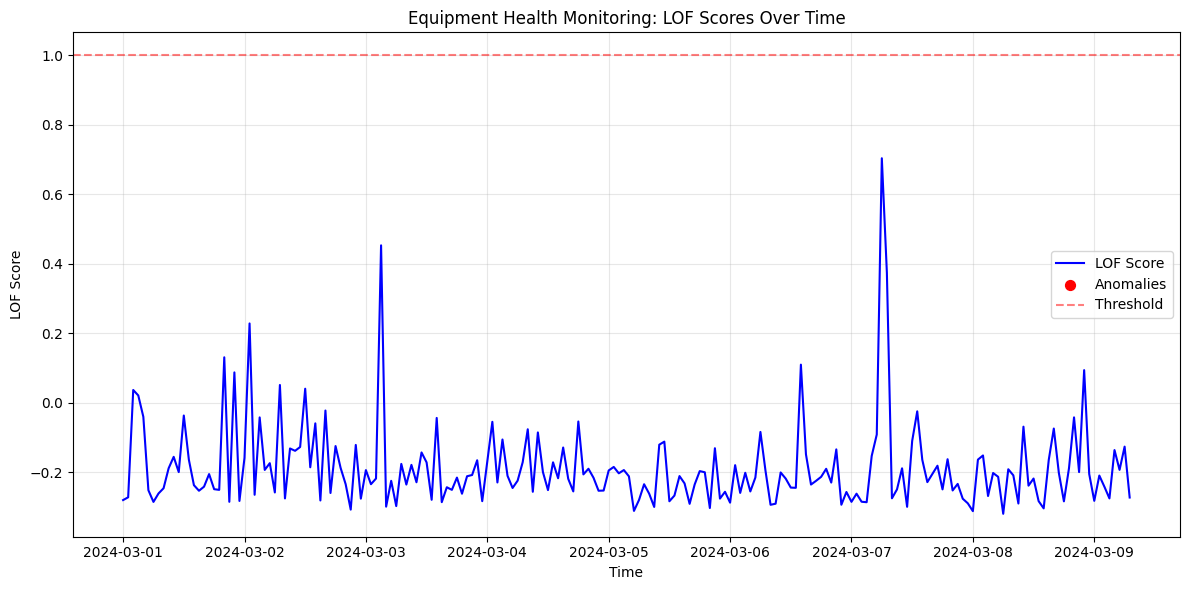

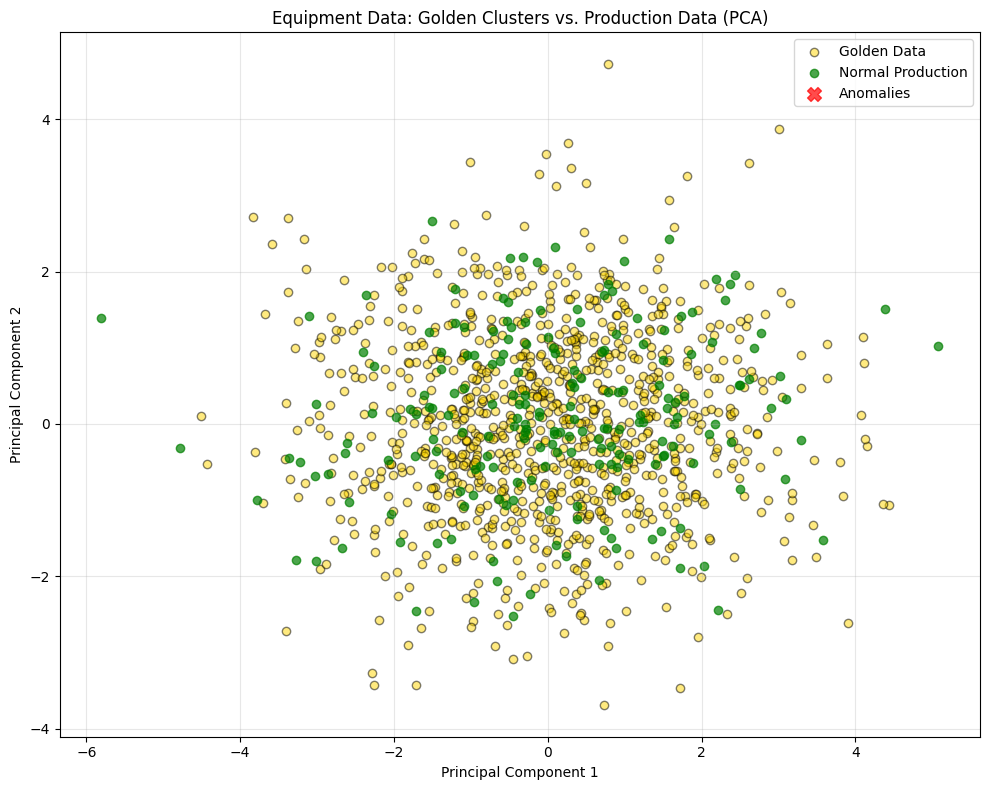

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

class EquipmentHealthForecasting:
    def __init__(self, n_neighbors=20, contamination=0.1):
        """
        Initialize the Equipment Health Forecasting using LOF algorithm

        Parameters:
        -----------
        n_neighbors : int, default=20
            Number of neighbors to consider for LOF calculation
        contamination : float, default=0.1
            Expected proportion of outliers in the dataset
        """
        self.n_neighbors = n_neighbors
        self.contamination = contamination
        self.lof = LocalOutlierFactor(
            n_neighbors=n_neighbors,
            contamination=contamination,
            novelty=True  # Set to True for predicting on new data
        )
        self.scaler = StandardScaler()
        self.golden_data = None
        self.feature_importance = None

    def train_with_golden_data(self, golden_data):
        """
        Train the model with Golden Data to form Golden Clusters

        Parameters:
        -----------
        golden_data : pandas DataFrame
            The "Golden Data" representing normal operating conditions
        """
        # Store original golden data
        self.golden_data = golden_data.copy()

        # Preprocess the data
        X = self.scaler.fit_transform(golden_data)

        # Fit the LOF model
        self.lof.fit(X)

        # Calculate feature importance based on PCA
        pca = PCA(n_components=min(5, golden_data.shape[1]))
        pca.fit(X)

        # Store feature importance for later use
        self.feature_importance = pd.DataFrame(
            np.abs(pca.components_),
            columns=golden_data.columns
        )

        print(f"Model trained with {golden_data.shape[0]} golden data points")
        return self

    def evaluate_health(self, production_data):
        """
        Evaluate equipment health by comparing production data against golden clusters

        Parameters:
        -----------
        production_data : pandas DataFrame
            New production data to evaluate

        Returns:
        --------
        health_metrics : pandas DataFrame
            DataFrame with health metrics including LOF scores
        """
        if self.golden_data is None:
            raise ValueError("Model not trained. Call train_with_golden_data first.")

        # Ensure production data has the same columns as golden data
        if not all(col in production_data.columns for col in self.golden_data.columns):
            raise ValueError("Production data columns don't match golden data columns")

        # Extract relevant columns and scale
        X = production_data[self.golden_data.columns]
        X_scaled = self.scaler.transform(X)

        # Calculate LOF scores for each data point (-1 * because sklearn returns negative values)
        lof_scores = -1 * self.lof.decision_function(X_scaled)

        # Calculate anomaly flag (1 for anomaly, 0 for normal)
        # Note: predict_proba is not available for LOF, so we use a threshold
        anomaly_flag = (lof_scores > 1).astype(int)

        # Create health metrics dataframe
        health_metrics = pd.DataFrame({
            'timestamp': production_data.index if isinstance(production_data.index, pd.DatetimeIndex) else None,
            'lof_score': lof_scores,
            'is_anomaly': anomaly_flag
        })

        # For anomalies, determine which features contributed most
        if anomaly_flag.sum() > 0:
            anomaly_indices = health_metrics[health_metrics['is_anomaly'] == 1].index
            health_metrics['contributing_features'] = None

            for idx in anomaly_indices:
                # Get the data point
                data_point = X_scaled[idx]

                # Compare with golden data mean
                golden_mean = np.mean(self.scaler.transform(self.golden_data), axis=0)
                deviation = np.abs(data_point - golden_mean)

                # Weight deviation by feature importance
                weighted_deviation = deviation * np.mean(self.feature_importance.values, axis=0)

                # Get top 3 contributing features
                top_features_idx = np.argsort(weighted_deviation)[-3:]
                top_features = [self.golden_data.columns[i] for i in top_features_idx]

                health_metrics.at[idx, 'contributing_features'] = ', '.join(top_features)

        return health_metrics

    def visualize_results(self, production_data, health_metrics):
        """
        Visualize the results of equipment health evaluation

        Parameters:
        -----------
        production_data : pandas DataFrame
            Production data that was evaluated
        health_metrics : pandas DataFrame
            Health metrics returned by evaluate_health
        """
        if 'timestamp' in health_metrics.columns and health_metrics['timestamp'] is not None:
            # Time series plot of LOF scores
            plt.figure(figsize=(12, 6))
            plt.plot(health_metrics['timestamp'], health_metrics['lof_score'], 'b-', label='LOF Score')

            # Highlight anomalies
            anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
            plt.scatter(anomalies['timestamp'], anomalies['lof_score'],
                        color='red', label='Anomalies', s=50)

            # Add a threshold line
            plt.axhline(y=1, color='r', linestyle='--', alpha=0.5, label='Threshold')

            plt.title('Equipment Health Monitoring: LOF Scores Over Time')
            plt.xlabel('Time')
            plt.ylabel('LOF Score')
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

        # PCA visualization of golden data vs production data
        X_golden = self.scaler.transform(self.golden_data)
        X_prod = self.scaler.transform(production_data[self.golden_data.columns])

        # Apply PCA
        pca = PCA(n_components=2)
        X_golden_pca = pca.fit_transform(X_golden)
        X_prod_pca = pca.transform(X_prod)

        plt.figure(figsize=(10, 8))

        # Plot golden data points
        plt.scatter(X_golden_pca[:, 0], X_golden_pca[:, 1],
                   c='gold', label='Golden Data', alpha=0.5, edgecolors='k')

        # Plot normal production data
        normal_idx = health_metrics[health_metrics['is_anomaly'] == 0].index
        plt.scatter(X_prod_pca[normal_idx, 0], X_prod_pca[normal_idx, 1],
                   c='green', label='Normal Production', alpha=0.7)

        # Plot anomalies
        anomaly_idx = health_metrics[health_metrics['is_anomaly'] == 1].index
        plt.scatter(X_prod_pca[anomaly_idx, 0], X_prod_pca[anomaly_idx, 1],
                   c='red', label='Anomalies', alpha=0.7, marker='X', s=100)

        plt.title('Equipment Data: Golden Clusters vs. Production Data (PCA)')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Feature importance visualization
        if len(anomaly_idx) > 0:
            plt.figure(figsize=(12, 8))
            feature_importance = self.feature_importance.mean().sort_values(ascending=False)
            sns.barplot(x=feature_importance.values, y=feature_importance.index)
            plt.title('Feature Importance in Anomaly Detection')
            plt.xlabel('Importance Score')
            plt.ylabel('Features (KeyNumbers)')
            plt.tight_layout()
            plt.show()

        return

# Example usage
if __name__ == "__main__":
    # Simulate golden data (normal operating conditions)
    np.random.seed(42)
    n_samples = 1000
    n_features = 8

    # Create feature names (KeyNumbers)
    feature_names = [f'KeyNumber_{i+1}' for i in range(n_features)]

    # Generate golden data with correlations
    mean = np.zeros(n_features)
    cov = np.eye(n_features)
    # Add some correlations
    for i in range(n_features):
        for j in range(n_features):
            if i != j:
                cov[i, j] = 0.3 if (i+j) % 2 == 0 else 0.1

    golden_data = np.random.multivariate_normal(mean, cov, n_samples)
    golden_df = pd.DataFrame(golden_data, columns=feature_names)

    # Create timestamp index
    date_rng = pd.date_range(start='2024-01-01', periods=n_samples, freq='H')
    golden_df.index = date_rng

    # Simulate production data (includes some anomalies)
    n_prod_samples = 200
    date_rng_prod = pd.date_range(start='2024-03-01', periods=n_prod_samples, freq='H')

    # Normal production data
    prod_data = np.random.multivariate_normal(mean, cov, n_prod_samples)

    # Introduce some anomalies
    anomaly_indices = [20, 50, 51, 100, 150, 151, 152]
    for idx in anomaly_indices:
        # Create different types of anomalies
        if idx % 3 == 0:
            # Type 1: Single feature extreme value
            feature_idx = idx % n_features
            prod_data[idx, feature_idx] = prod_data[idx, feature_idx] + 5
        elif idx % 3 == 1:
            # Type 2: Multiple features deviating
            prod_data[idx, :3] = prod_data[idx, :3] + 2
        else:
            # Type 3: Pattern change (correlation break)
            prod_data[idx] = np.random.normal(0, 1, n_features)

    prod_df = pd.DataFrame(prod_data, columns=feature_names)
    prod_df.index = date_rng_prod

    # Initialize and train the model
    ehf = EquipmentHealthForecasting(n_neighbors=15, contamination=0.05)
    ehf.train_with_golden_data(golden_df)

    # Evaluate production data
    health_metrics = ehf.evaluate_health(prod_df)

    # Print results
    print("\nHealth Metrics Summary:")
    print(f"Total data points: {len(health_metrics)}")
    print(f"Detected anomalies: {health_metrics['is_anomaly'].sum()}")

    # Show anomalies with contributing features
    if health_metrics['is_anomaly'].sum() > 0:
        anomalies = health_metrics[health_metrics['is_anomaly'] == 1]
        print("\nDetected Anomalies:")
        for idx, row in anomalies.iterrows():
            print(f"Timestamp: {row['timestamp']} | LOF Score: {row['lof_score']:.4f} | Contributing Features: {row['contributing_features']}")

    # Visualize results
    ehf.visualize_results(prod_df, health_metrics)